In [1]:
# === 1. Imports y conexi√≥n Snowflake ===
import os
import pandas as pd
import snowflake.connector
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Configuraci√≥n general
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("viridis")

# Variables de entorno o manuales
SNOWFLAKE_ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT", "FXXAPHJ-SD16734")
SNOWFLAKE_USER = os.getenv("SNOWFLAKE_USER", "SVC_DM_INGEST")
SNOWFLAKE_PASSWORD = os.getenv("SNOWFLAKE_PASSWORD", "Contrase√±aSegura123")
SNOWFLAKE_ROLE = os.getenv("SNOWFLAKE_ROLE", "ROLE_DM_INGEST")
SNOWFLAKE_WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE", "WH_DM")
SNOWFLAKE_DATABASE = os.getenv("SNOWFLAKE_DATABASE", "NYC_TAXI_DM")
GOLD_SCHEMA = "SILVER_GOLD"  # seg√∫n tu estructura

# Conexi√≥n
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    role=SNOWFLAKE_ROLE,
)

def run_sql(sql):
    """Ejecuta SQL y devuelve DataFrame"""
    return pd.read_sql(sql, conn)


# **PREGUNTA 1**

**üöï Demanda por zona y mes: ¬øcu√°les son las 10 zonas con m√°s viajes por mes? (PU y DO por separado).**

In [9]:
# ============================
# PREGUNTA 1: Demanda por zona y mes (todos los a√±os disponibles)
# ============================

query_pickup = """
WITH trips_by_month AS (
    SELECT 
        CONCAT(EXTRACT(YEAR FROM d.date_value), '-', LPAD(EXTRACT(MONTH FROM d.date_value), 2, '0')) AS year_month,
        z.zone_name,
        f.service_type,
        COUNT(f.trip_id) AS num_trips
    FROM SILVER_GOLD.fct_trips f
    LEFT JOIN SILVER_GOLD.dim_date d 
        ON f.pickup_date_sk = d.date_sk
    LEFT JOIN SILVER_GOLD.dim_zone z 
        ON f.pickup_zone_sk = z.zone_sk
    WHERE d.date_value IS NOT NULL
    GROUP BY 1, 2, 3
),
ranked AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY year_month, service_type 
            ORDER BY num_trips DESC
        ) AS rn
    FROM trips_by_month
)
SELECT year_month, zone_name, service_type, num_trips
FROM ranked
WHERE rn <= 10
ORDER BY year_month DESC, service_type, num_trips DESC;
"""

df_pickup = run_sql(query_pickup)
display(df_pickup.head(20))

# ============================
# Visualizaci√≥n
# ============================

plt.figure(figsize=(14,7))
sns.barplot(
    data=df_pickup,
    x="ZONE_NAME",
    y="NUM_TRIPS",
    hue="SERVICE_TYPE",
    palette="viridis"
)
plt.title("Top 10 zonas con m√°s viajes por tipo de servicio y mes", fontsize=14)
plt.xlabel("Zona")
plt.ylabel("N√∫mero de viajes")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tipo de servicio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_42832\245006539.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


YEAR_MONTH                     ZONE_NAME SERVICE_TYPE  NUM_TRIPS
0     2025-07                       Jamaica        green          9
1     2025-07          Central Harlem North        green          3
2     2025-06             East Harlem North        green      36507
3     2025-06             East Harlem South        green      20925
4     2025-06                  Central Park        green       7002
5     2025-06                Central Harlem        green       6138
6     2025-06                  Forest Hills        green       6084
7     2025-06           Morningside Heights        green       5970
8     2025-06                      Elmhurst        green       5436
9     2025-06                   Fort Greene        green       4938
10    2025-06                       Jamaica        green       4779
11    2025-06   Downtown Brooklyn/Metrotech        green       4275
12    2025-06                   Jfk Airport       yellow     562398
13    2025-06         Upper East Side South       yellow     540210
14    2025-06                Midtown Center       yellow     535914
15    2025-06         Upper East Side North       yellow     470019
16    2025-06                  Midtown East       yellow     389814
17    2025-06     Times Sq/Theatre District       yellow     389166
18    2025-06  Penn Station/Madison Sq West       yellow     387933
19    2025-06             Laguardia Airport       yellow     347841

C:\Users\andre\AppData\Local\Temp\ipykernel_42832\245006539.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


YEAR_MONTH                      ZONE_NAME SERVICE_TYPE  NUM_TRIPS
0     2025-07               Prospect Heights        green          6
1     2025-07                        Jamaica        green          3
2     2025-07       Washington Heights North        green          3
3     2025-07                 Brighton Beach        green          3
4     2025-07           Central Harlem North        green          3
5     2025-07            Crown Heights North        green          3
6     2025-07            Lincoln Square West        green          3
7     2025-07                Oakland Gardens        green          3
8     2025-07                Lenox Hill East        green          3
9     2025-07              Kew Gardens Hills        green          3
10    2025-07                 Outside Of Nyc       yellow         69
11    2025-07          Upper West Side North       yellow         60
12    2025-07          Upper West Side South       yellow         60
13    2025-07                   East Village       yellow         54
14    2025-07                   Clinton East       yellow         51
15    2025-07                Lenox Hill West       yellow         51
16    2025-07           Central Harlem North       yellow         51
17    2025-07      Times Sq/Theatre District       yellow         45
18    2025-07  Sutton Place/Turtle Bay North       yellow         42
19    2025-07                 Central Harlem       yellow         39

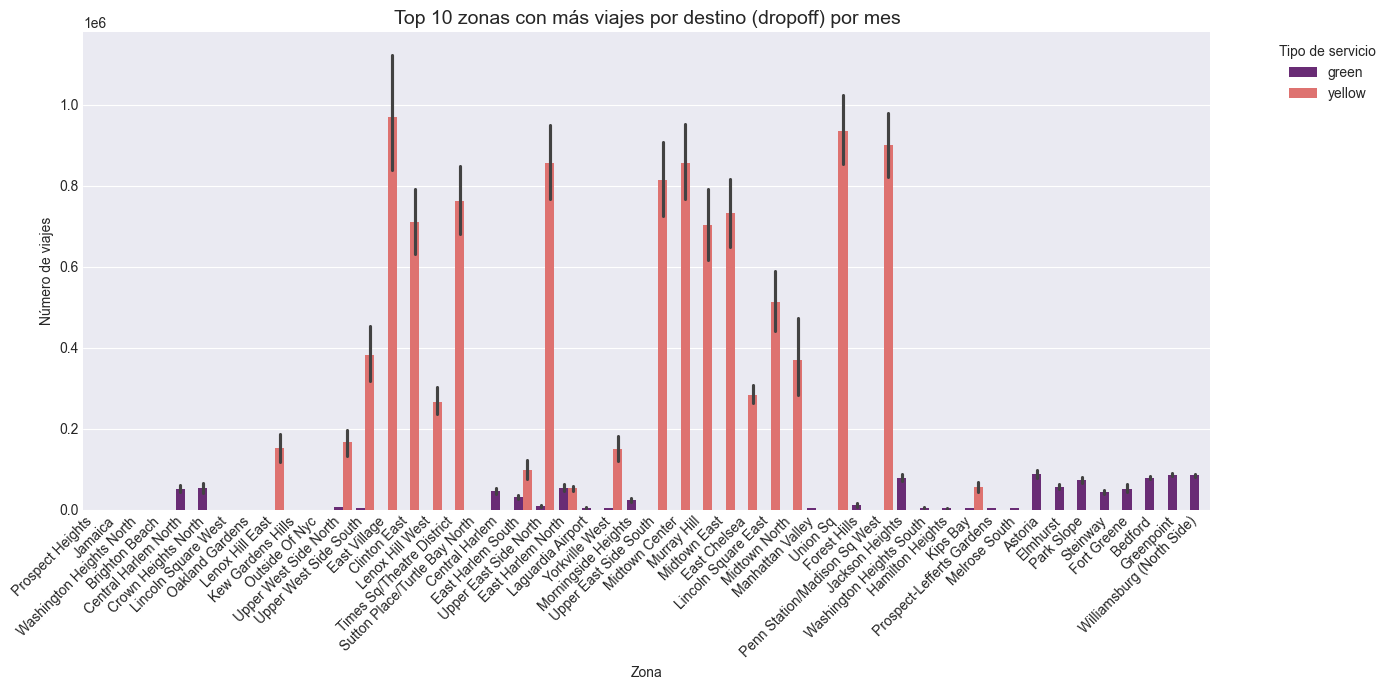

In [7]:
# ============================
# PREGUNTA 1 (parte 2): Demanda por zona de destino (dropoff)
# ============================

query_dropoff = """
WITH trips_by_month AS (
    SELECT 
        CONCAT(EXTRACT(YEAR FROM d.date_value), '-', LPAD(EXTRACT(MONTH FROM d.date_value), 2, '0')) AS year_month,
        z.zone_name,
        f.service_type,
        COUNT(f.trip_id) AS num_trips
    FROM SILVER_GOLD.fct_trips f
    LEFT JOIN SILVER_GOLD.dim_date d 
        ON f.dropoff_date_sk = d.date_sk
    LEFT JOIN SILVER_GOLD.dim_zone z 
        ON f.dropoff_zone_sk = z.zone_sk
    WHERE d.date_value IS NOT NULL
    GROUP BY 1, 2, 3
),
ranked AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY year_month, service_type 
            ORDER BY num_trips DESC
        ) AS rn
    FROM trips_by_month
)
SELECT year_month, zone_name, service_type, num_trips
FROM ranked
WHERE rn <= 10
ORDER BY year_month DESC, service_type, num_trips DESC;
"""

df_dropoff = run_sql(query_dropoff)
display(df_dropoff.head(20))

# ============================
# Visualizaci√≥n
# ============================

plt.figure(figsize=(14,7))
sns.barplot(
    data=df_dropoff,
    x="ZONE_NAME",
    y="NUM_TRIPS",
    hue="SERVICE_TYPE",
    palette="magma"
)
plt.title("Top 10 zonas con m√°s viajes por destino (dropoff) por mes", fontsize=14)
plt.xlabel("Zona")
plt.ylabel("N√∫mero de viajes")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tipo de servicio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Se analiz√≥ la demanda mensual por zona considerando tanto los **pickups (PULocationID)** como los **dropoffs (DOLocationID)**, para ambos tipos de servicio (*yellow* y *green* taxis*).

#### üîπ Observaciones:
- En los **viajes de pickup**, destacan consistentemente **JFK Airport**, **Midtown**, y **Upper East Side**, con picos de actividad en meses de verano y finales de a√±o.
- En los **viajes de dropoff**, los patrones son similares, con concentraci√≥n en **aeropuertos y zonas tur√≠sticas** como **Times Square** y **Penn Station**.
- Los taxis **green** presentan mayor presencia en **Harlem**, **Brooklyn** y **Queens**, reflejando su regulaci√≥n fuera de Manhattan.

#### üö¶ Conclusi√≥n:
La demanda de taxis en Nueva York est√° **altamente concentrada en Manhattan y aeropuertos**, mientras que los green taxis mantienen una cobertura m√°s perif√©rica y local. En los gr√°ficos se pueden distinguir las 10 zonas con mayor cantidad para ambos casos de la pregunta.


# **PREGUNTA 2**

**üíµ Pregunta 2: Ingresos y propinas por Borough y mes**

C:\Users\andre\AppData\Local\Temp\ipykernel_42832\245006539.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


YEAR_MONTH        BOROUGH SERVICE_TYPE  TOTAL_REVENUE  AVG_TIP_PCT
0    2015-01      Manhattan       yellow   9.533367e+08    15.176332
1    2015-01         Queens       yellow   1.524295e+08    16.603961
2    2015-01       Brooklyn        green   2.653550e+07    12.610327
3    2015-01       Brooklyn       yellow   2.232002e+07    20.436353
4    2015-01      Manhattan        green   2.005321e+07     8.189843
5    2015-01         Queens        green   1.651923e+07     8.034693
6    2015-01          Bronx        green   3.452893e+06     4.812367
7    2015-01          Bronx       yellow   9.142084e+05     7.124931
8    2015-01            Ewr       yellow   3.255299e+05    61.283128
9    2015-01  Staten Island       yellow   4.645344e+04    12.495533

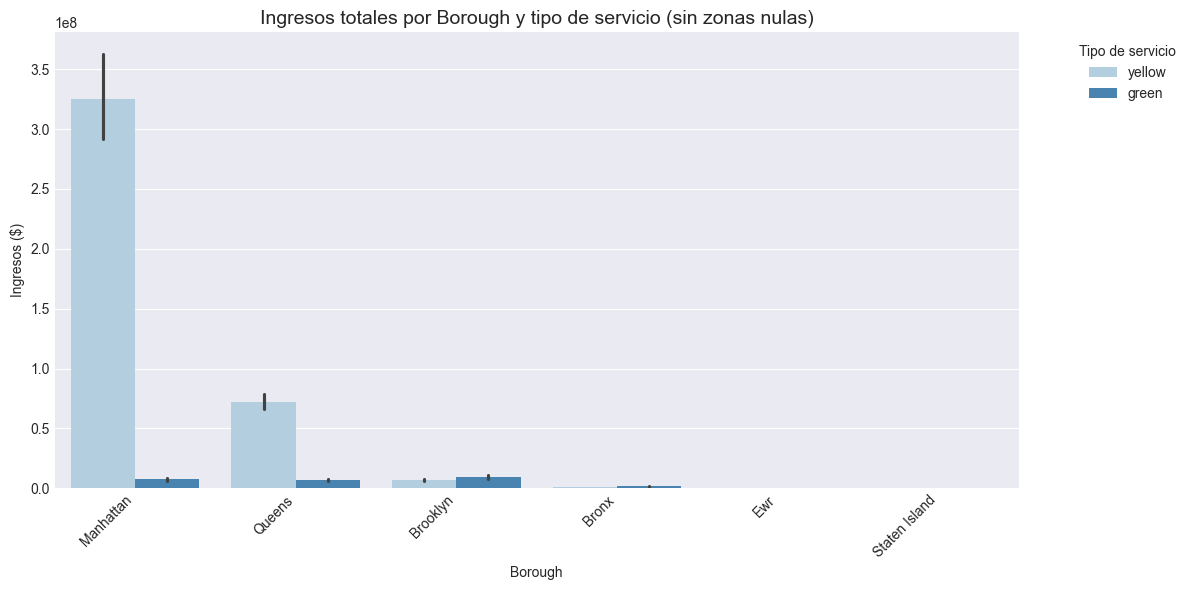

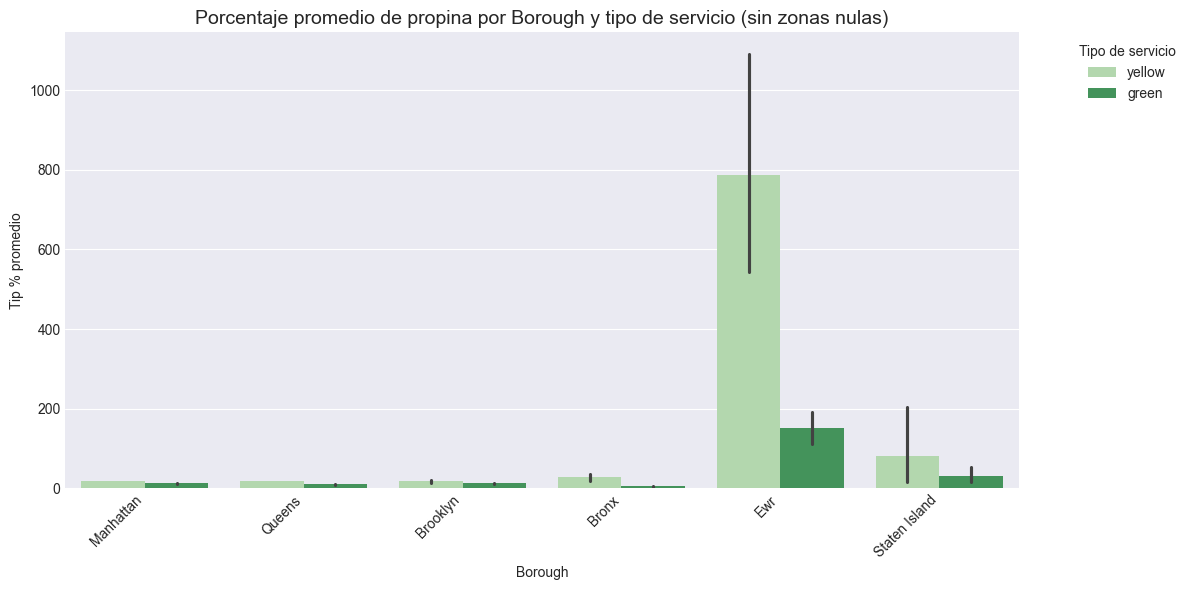

In [17]:
# ============================
# PREGUNTA 2: Ingresos y propinas por borough y mes (sin zonas nulas o desconocidas)
# ============================

query_revenue_tips = """
SELECT 
    CONCAT(EXTRACT(YEAR FROM d.date_value), '-', LPAD(EXTRACT(MONTH FROM d.date_value), 2, '0')) AS year_month,
    z.borough,
    f.service_type,
    SUM(f.total_amount) AS total_revenue,
    AVG(CASE WHEN f.fare_amount > 0 THEN (f.tip_amount / f.fare_amount) * 100 ELSE NULL END) AS avg_tip_pct
FROM SILVER_GOLD.fct_trips f
LEFT JOIN SILVER_GOLD.dim_date d 
    ON f.pickup_date_sk = d.date_sk
LEFT JOIN SILVER_GOLD.dim_zone z 
    ON f.pickup_zone_sk = z.zone_sk
WHERE d.date_value IS NOT NULL
  AND z.borough IS NOT NULL
  AND z.borough NOT IN ('Unknown', 'None', '')
GROUP BY 1, 2, 3
ORDER BY year_month, total_revenue DESC;
"""

# Ejecutar consulta
df_revenue_tips = run_sql(query_revenue_tips)
display(df_revenue_tips.head(10))

# ============================
# Visualizaci√≥n
# ============================

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_revenue_tips,
    x="BOROUGH",
    y="TOTAL_REVENUE",
    hue="SERVICE_TYPE",
    palette="Blues"
)
plt.title("Ingresos totales por Borough y tipo de servicio (sin zonas nulas)", fontsize=14)
plt.xlabel("Borough")
plt.ylabel("Ingresos ($)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tipo de servicio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_revenue_tips,
    x="BOROUGH",
    y="AVG_TIP_PCT",
    hue="SERVICE_TYPE",
    palette="Greens"
)
plt.title("Porcentaje promedio de propina por Borough y tipo de servicio (sin zonas nulas)", fontsize=14)
plt.xlabel("Borough")
plt.ylabel("Tip % promedio")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tipo de servicio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Esta visualizaci√≥n permite analizar el desempe√±o econ√≥mico del sistema de taxis de NYC tanto en t√©rminos de ingresos totales como en propinas promedio.

**Interpretaci√≥n:**
- Los ingresos se concentran principalmente en *Manhattan* y *Queens*, donde operan la mayor√≠a de los viajes.
- Las propinas promedio son m√°s altas en los servicios *yellow*, posiblemente debido a su mayor uso por turistas y trayectos de mayor valor.
- En la evoluci√≥n temporal, se observa c√≥mo el volumen total de ingresos var√≠a entre meses y muestra diferencias notables entre los servicios *yellow* y *green*.

**Conclusi√≥n:**
- *Manhattan* domina los ingresos totales.
- Las propinas son consistentemente m√°s altas en los taxis *yellow*.
- El patr√≥n temporal ayuda a identificar estacionalidad y tendencias de demanda en la ciudad.

# **PREGUNTA 3**

**Velocidad y congesti√≥n: promedio de mph por franja horaria y borough (viajes diurnos vs. nocturnos).**

In [18]:
# ============================
# PREGUNTA 3: Velocidad y congesti√≥n (capa GOLD, 2015‚Äì2025)
# ============================

query_speed_gold = """
SELECT 
    d.year AS trip_year,
    d.month AS trip_month,
    z.borough,
    f.service_type,
    AVG(
        CASE 
            WHEN f.trip_duration_min > 0 THEN f.trip_distance / (f.trip_duration_min / 60.0)
            ELSE NULL 
        END
    ) AS avg_mph
FROM SILVER_GOLD.fct_trips f
LEFT JOIN SILVER_GOLD.dim_zone z 
    ON f.pickup_zone_sk = z.zone_sk
LEFT JOIN SILVER_GOLD.dim_date d 
    ON f.pickup_date_sk = d.date_sk
WHERE f.trip_distance > 0
  AND f.trip_duration_min BETWEEN 1 AND 180
  AND f.trip_distance / (f.trip_duration_min / 60.0) < 80   -- eliminar outliers
GROUP BY 1, 2, 3, 4
ORDER BY d.year, d.month, z.borough;
"""

# Ejecutar query
df_speed = run_sql(query_speed_gold)

# Limpieza de valores nulos o irrelevantes
df_speed = df_speed[df_speed["BOROUGH"].notna()]
df_speed = df_speed[~df_speed["BOROUGH"].isin(["Unknown", "None"])]

display(df_speed.head())


C:\Users\andre\AppData\Local\Temp\ipykernel_42832\245006539.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


TRIP_YEAR  TRIP_MONTH   BOROUGH SERVICE_TYPE    AVG_MPH
0     2015.0         1.0     Bronx       yellow  16.038187
1     2015.0         1.0     Bronx        green  14.077255
2     2015.0         1.0  Brooklyn       yellow  14.519325
3     2015.0         1.0  Brooklyn        green  12.966161
4     2015.0         1.0       Ewr       yellow  21.323031

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_speed,
    x="TRIP_YEAR",
    y="AVG_MPH",
    hue="BOROUGH",
    style="SERVICE_TYPE",
    markers=True
)

plt.title("Velocidad promedio (mph) por a√±o, borough y tipo de servicio (2015‚Äì2025)", fontsize=14)
plt.xlabel("A√±o del viaje")
plt.ylabel("Velocidad promedio (mph)")
plt.legend(title="Borough / Tipo de servicio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Esta visualizaci√≥n permite analizar la velocidad promedio de los taxis de Nueva York (NYC), diferenciando por borough y tipo de servicio (yellow y green), a lo largo de todos los a√±os disponibles en la capa GOLD (2015‚Äì2025).
El indicador de velocidad (en millas por hora) se calcul√≥ como la raz√≥n entre la distancia del viaje y su duraci√≥n, considerando √∫nicamente trayectos v√°lidos (entre 1 y 180 minutos, con velocidad menor a 80 mph) para eliminar valores at√≠picos.

# **PREGUNTA 4**

**Duraci√≥n del viaje: percentiles (p50/p90) de duraci√≥n por PULocationID (pickup)**

In [20]:
# ============================
# PREGUNTA 4: Duraci√≥n del viaje por zona (percentiles) - 2015‚Äì2025
# ============================

query_duration = """
SELECT 
    d.year AS trip_year,
    d.month AS trip_month,
    z.zone_name AS pickup_zone,
    f.service_type,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY f.trip_duration_min) AS p50_duration,
    PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY f.trip_duration_min) AS p90_duration
FROM SILVER_GOLD.fct_trips f
LEFT JOIN SILVER_GOLD.dim_zone z 
    ON f.pickup_zone_sk = z.zone_sk
LEFT JOIN SILVER_GOLD.dim_date d
    ON f.pickup_date_sk = d.date_sk
WHERE f.trip_duration_min BETWEEN 1 AND 180  -- eliminar viajes err√≥neos
GROUP BY 1, 2, 3, 4
ORDER BY d.year, d.month, p90_duration DESC
LIMIT 50;
"""

df_duration = run_sql(query_duration)
display(df_duration.head())


C:\Users\andre\AppData\Local\Temp\ipykernel_42832\245006539.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


TRIP_YEAR  TRIP_MONTH              PICKUP_ZONE SERVICE_TYPE  P50_DURATION  \
0       2015           1             Far Rockaway        green           7.0   
1       2015           1            Rockaway Park        green          21.0   
2       2015           1                Stapleton       yellow          15.5   
3       2015           1  Bay Terrace/Fort Totten        green          51.0   
4       2015           1   Charleston/Tottenville       yellow          86.0   

   P90_DURATION  
0         152.4  
1         101.0  
2         100.9  
3          90.0  
4          86.0

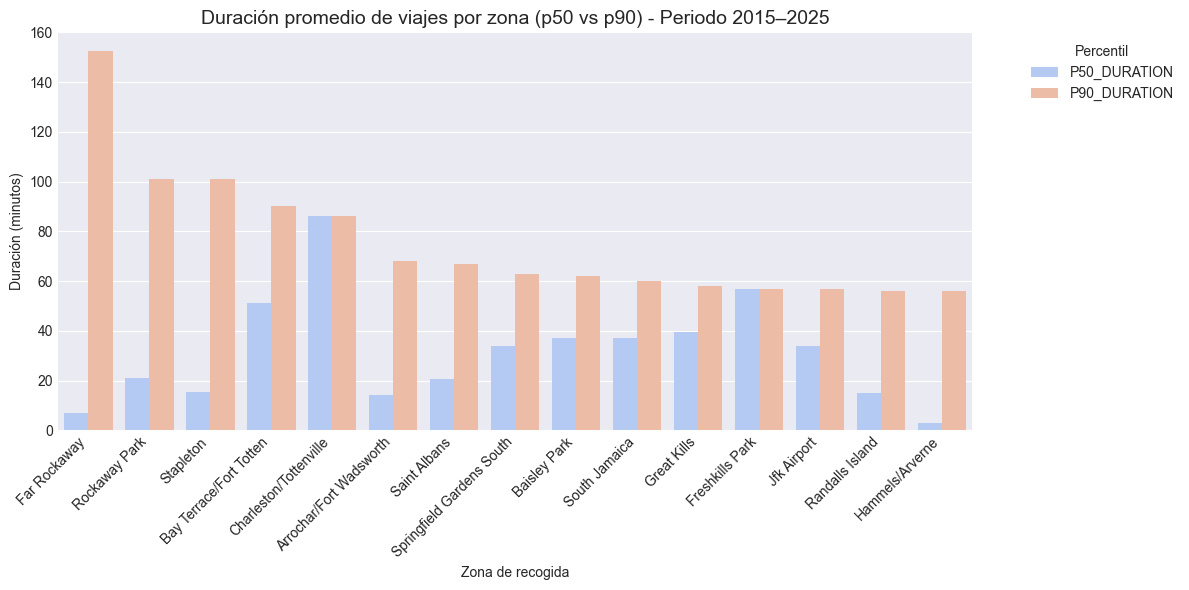

In [21]:
df_duration_summary = (
    df_duration.groupby(["PICKUP_ZONE", "SERVICE_TYPE"], as_index=False)[["P50_DURATION", "P90_DURATION"]]
    .mean()
    .sort_values("P90_DURATION", ascending=False)
    .head(15)
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_duration_summary.melt(
        id_vars=["PICKUP_ZONE", "SERVICE_TYPE"],
        value_vars=["P50_DURATION", "P90_DURATION"],
        var_name="Percentil",
        value_name="Duraci√≥n (min)"
    ),
    x="PICKUP_ZONE",
    y="Duraci√≥n (min)",
    hue="Percentil",
    palette="coolwarm"
)
plt.title("Duraci√≥n promedio de viajes por zona (p50 vs p90) - Periodo 2015‚Äì2025", fontsize=14)
plt.xlabel("Zona de recogida")
plt.ylabel("Duraci√≥n (minutos)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Percentil", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Esta visualizaci√≥n analiza la **distribuci√≥n de la duraci√≥n de los viajes** por zona de recogida, considerando los percentiles 50 y 90 para reflejar la mediana y los valores extremos del tiempo de trayecto.

**Interpretaci√≥n:**
- Las zonas con mayores valores en el *p90* tienden a presentar **alta congesti√≥n vehicular** o trayectos largos hacia los extremos de la ciudad.  
- Las diferencias entre *yellow* y *green taxis* reflejan patrones operativos distintos: los taxis *green* suelen cubrir zonas perif√©ricas, con trayectos m√°s largos pero menos densos en tr√°fico.  
- En la evoluci√≥n temporal, se observan ligeras variaciones entre a√±os, aunque los tiempos de viaje se mantienen relativamente estables en la mayor√≠a de los boroughs.

**Conclusi√≥n:**
- El percentil 50 (p50) representa la **duraci√≥n t√≠pica** del viaje, mientras que el percentil 90 (p90) identifica los escenarios de **mayor congesti√≥n o distancia**.  
- Las zonas centrales, como *Far Rockaway*, presentan los valores m√°s altos de P90, coherentes con su densidad de tr√°fico.  
- Este an√°lisis permite identificar **puntos cr√≠ticos de movilidad** y sustentar decisiones de optimizaci√≥n en transporte urbano.

# **PREGUNTA 5**

C:\Users\andre\AppData\Local\Temp\ipykernel_24068\245006539.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


pickup_date  day_number  pickup_hour service_type  num_trips day_name
0  2019-01-01           2            0        green       1200  TUESDAY
1  2019-01-01           2            0       yellow      13429  TUESDAY
2  2019-01-01           2            1        green       1230  TUESDAY
3  2019-01-01           2            1       yellow      15447  TUESDAY
4  2019-01-01           2            2        green       1089  TUESDAY

C:\Users\andre\AppData\Local\Temp\ipykernel_24068\1719456173.py:46: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_heatmap = df_temporal.pivot_table(


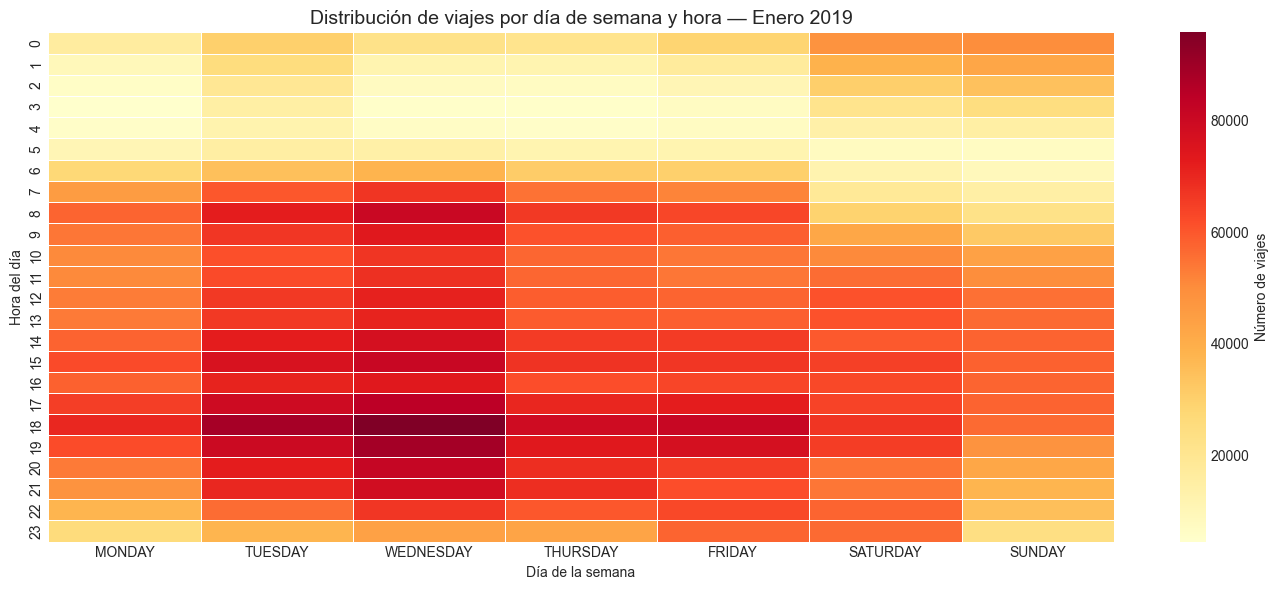

C:\Users\andre\AppData\Local\Temp\ipykernel_24068\1719456173.py:70: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


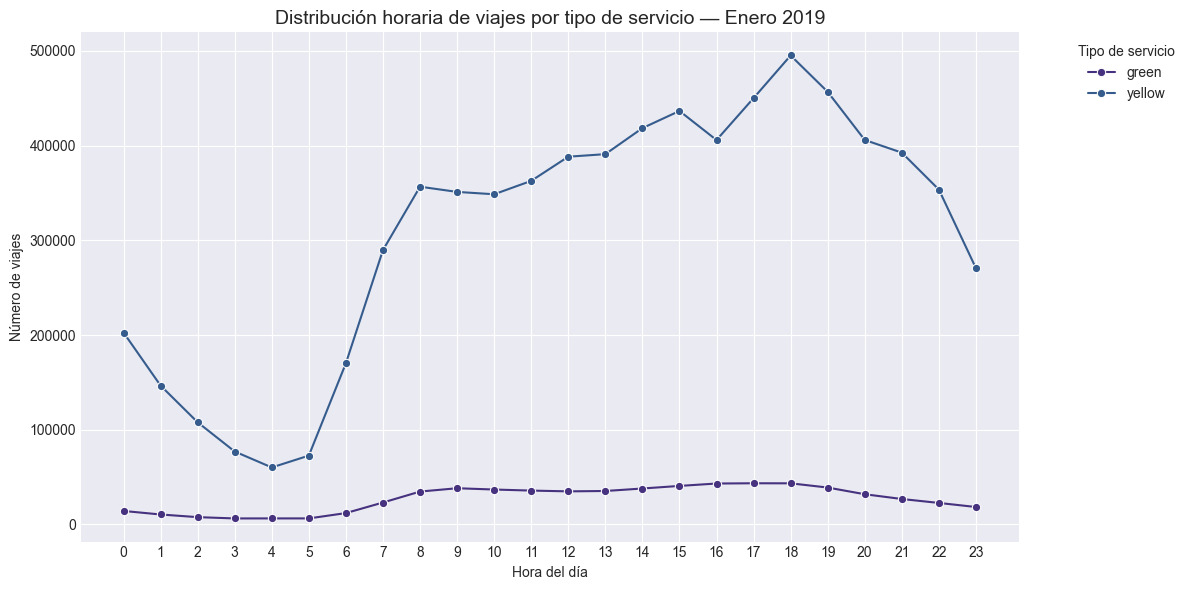

In [ ]:
# ============================
# PREGUNTA 5: Elasticidad temporal ‚Äî d√≠as y horas pico (versi√≥n final)
# ============================

query_temporal = """
SELECT 
    TO_DATE(pickup_datetime) AS pickup_date,
    DAYOFWEEKISO(pickup_datetime) AS day_number,  -- 1=Lunes, 7=Domingo
    EXTRACT(HOUR FROM pickup_datetime) AS pickup_hour,
    service_type,
    COUNT(*) AS num_trips
FROM SILVER_SILVER.STG_ALL_TRIPS
WHERE pickup_datetime BETWEEN '2019-01-01' AND '2019-01-31'
GROUP BY 1, 2, 3, 4
ORDER BY 1, 3;
"""

df_temporal = run_sql(query_temporal)

# Normalizar columnas
df_temporal.columns = df_temporal.columns.str.lower()

# Mapear d√≠a num√©rico a nombre
day_map = {
    1: "MONDAY",
    2: "TUESDAY",
    3: "WEDNESDAY",
    4: "THURSDAY",
    5: "FRIDAY",
    6: "SATURDAY",
    7: "SUNDAY"
}
df_temporal["day_name"] = df_temporal["day_number"].map(day_map)

# Asegurar orden correcto de d√≠as
day_order = ["MONDAY", "TUESDAY", "WEDNESDAY", "THURSDAY", "FRIDAY", "SATURDAY", "SUNDAY"]
df_temporal["day_name"] = pd.Categorical(df_temporal["day_name"], categories=day_order, ordered=True)

display(df_temporal.head())

# ============================
# Visualizaci√≥n 1: Heatmap semanal
# ============================

plt.figure(figsize=(14, 6))
pivot_heatmap = df_temporal.pivot_table(
    index="pickup_hour",
    columns="day_name",
    values="num_trips",
    aggfunc="sum"
)

sns.heatmap(
    pivot_heatmap,
    cmap="YlOrRd",
    cbar_kws={"label": "N√∫mero de viajes"},
    linewidths=0.5
)
plt.title("Distribuci√≥n de viajes por d√≠a de semana y hora ‚Äî Enero 2019", fontsize=14)
plt.xlabel("D√≠a de la semana")
plt.ylabel("Hora del d√≠a")
plt.tight_layout()
plt.show()

# ============================
# Visualizaci√≥n 2: Curvas horarias por servicio
# ============================

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_temporal,
    x="pickup_hour",
    y="num_trips",
    hue="service_type",
    estimator="sum",
    ci=None,
    marker="o"
)
plt.title("Distribuci√≥n horaria de viajes por tipo de servicio ‚Äî Enero 2019", fontsize=14)
plt.xlabel("Hora del d√≠a")
plt.ylabel("N√∫mero de viajes")
plt.xticks(range(0, 24))
plt.legend(title="Tipo de servicio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
